In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from sklearn.linear_model import LogisticRegression#, Ridge
#from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

sys.path.append('../models/')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
DATA_PATH =  '../../data/cluster/year/'
HISTORIC_DATA_PATH = '../../data/cluster/historic/'

In [3]:
X_train = pd.read_csv(DATA_PATH + 'X_train_full.csv')
X_valid = pd.read_csv(DATA_PATH + 'X_valid_full.csv')
X_test  = pd.read_csv(DATA_PATH + 'X_test_full.csv')
y_train = pd.read_csv(DATA_PATH + 'y_train_full.csv')
y_valid = pd.read_csv(DATA_PATH + 'y_valid_full.csv')
y_test  = pd.read_csv(DATA_PATH + 'y_test_full.csv')

X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_valid = X_valid.drop(['Unnamed: 0'], axis=1)
X_test  = X_test.drop(['Unnamed: 0'],  axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_valid = y_valid.drop(['Unnamed: 0'], axis=1)
y_test  = y_test.drop(['Unnamed: 0'],  axis=1)

full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']



# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year', 'varPrecip_growingSeason'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year', 'varPrecip_growingSeason'], axis=1)
X_test  = X_test.drop(['studyArea',  'x', 'y', 'elev_srtm30', 'year', 'varPrecip_growingSeason'],  axis=1)

predictors = list(X_train)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'next_year_beetle']


In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [5]:
y_train = y_train['beetle'].values.reshape(-1)
y_valid = y_valid['beetle'].values.reshape(-1)
y_test  = y_test['beetle'].values.reshape(-1)

In [6]:
logistic_clf = LogisticRegression(C=0.001923583801, penalty='l1')
logistic_clf.fit(X_train, y_train)
preds = logistic_clf.predict(X_test)
accuracy = sum(y_test == preds) / len(preds)
accuracy

0.93209509405747104

In [7]:
preds = logistic_clf.predict(X_test)

In [8]:
pred_ps = logistic_clf.predict_proba(X_test)
pred_ps = np.array([p[1] for p in pred_ps])

In [9]:
auc_metrics_full = util.get_auc(y_test, pred_ps)

AUC:       0.945848019112


In [10]:
[[X_train, y_train], 
 [X_valid, y_valid], 
 [X_test, y_test]] = util.load_data(DATA_PATH)

X_train: (529623, 24)
X_valid: (176541, 24)
X_test: (176541, 24)
y_train: (529623, 1)
y_valid: (176541, 1)
y_test: (176541, 1)


In [11]:
sq_fields = [
    'meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug',
    'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan',
    'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual',
    'precip_JunAug', 'precipPrevious_JunAug', 'precip_OctSep',
    'precipPrevious_OctSep', 'precip_growingSeason',
    'elev_etopo1', 'lat', 'lon']
interactions = [
    'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep',
    'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct',
    'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual',
    'precip_OctSep:meanTemp_Aug', 'precip_OctSep:meanMinTemp_Oct',
    'precip_OctSep:elev_etopo1', 'precip_OctSep:elev_etopo1',
    'precip_OctSep:lat', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:precipPrevious_OctSep',
    'precip_OctSep:precip_meanAnnual', 'precip_OctSep:precip_OctSep',
    'meanMaxTemp_Aug:precip_OctSep', 'meanTemp_AprAug:precip_OctSep',
    'precip_OctSep:varPrecip_growingSeason', 'meanTemp_Aug:precip_OctSep']

In [12]:
def make_squared(dataframe, fields):
    df = dataframe.copy()
    for field in fields:
        df['%s_sq' % field] = df[field] ** 2
    return df

In [13]:
def make_interactions(dataframe, interactions):
    df = dataframe.copy()
    for interaction in interactions:
        main_effects = interaction.split(':')
        df[interaction] = df[main_effects[0]] * df[main_effects[1]]
    return df

In [14]:
X_train = make_squared(X_train, sq_fields)
X_valid = make_squared(X_valid, sq_fields)
X_test  = make_squared(X_test, sq_fields)

X_train = make_interactions(X_train, interactions)
X_valid = make_interactions(X_valid, interactions)
X_test  = make_interactions(X_test, interactions)

In [15]:
full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']

In [16]:
X_train = X_train.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)
X_valid = X_valid.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)
X_test  = X_test.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)


predictors = list(X_train)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'meanTemp_Annual_sq', 'meanTemp_AprAug_sq', 'meanTemp_Aug_sq', 'meanMinTemp_DecFeb_sq', 'meanMinTemp_Oct_sq', 'meanMinTemp_Jan_sq', 'meanMinTemp_Mar_sq', 'meanMaxTemp_Aug_sq', 'precip_meanAnnual_sq', 'precip_JunAug_sq', 'precipPrevious_JunAug_sq', 'precip_OctSep_sq', 'precipPrevious_OctSep_sq', 'precip_growingSeason_sq', 'elev_etopo1_sq', 'lat_sq', 'lon_sq', 'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep', 'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct', 'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason', 'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual', 'precip_OctSep:meanTemp_Aug', 'precip_OctSep:m

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [18]:
y_train = y_train['beetle'].values.reshape(-1)
y_valid = y_valid['beetle'].values.reshape(-1)
y_test  = y_test['beetle'].values.reshape(-1)

In [19]:
logistic_clf = LogisticRegression(C=0.001, penalty='l2')
logistic_clf.fit(X_train, y_train)
preds = logistic_clf.predict(X_test)
accuracy = sum(y_test == preds) / len(preds)
accuracy

0.88458205176134719

In [20]:
pred_ps = logistic_clf.predict_proba(X_test)
pred_ps = np.array([p[1] for p in pred_ps])

In [21]:
auc_metrics_no_beetle = util.get_auc(y_test, pred_ps)

AUC:       0.918877660293


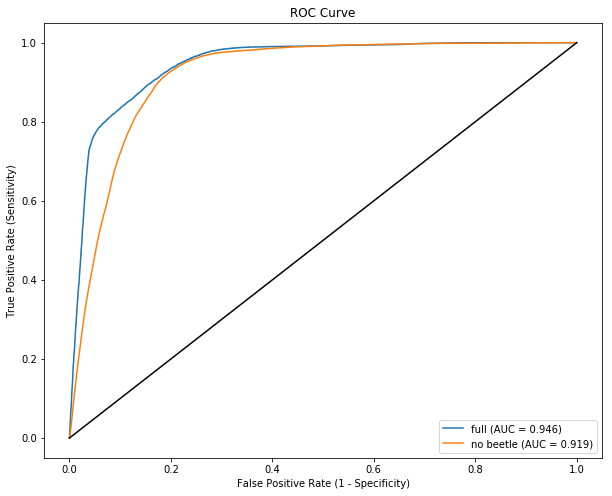

In [22]:
plt.plot(auc_metrics_full['fpr'], 
         auc_metrics_full['tpr'], 
         label='full (AUC = 0.946)');
plt.plot(auc_metrics_no_beetle['fpr'], 
         auc_metrics_no_beetle['tpr'], 
         label='no beetle (AUC = 0.919)');
plt.plot([0, 1], [0, 1], 'k');
plt.xlabel('False Positive Rate (1 - Specificity)');
plt.ylabel('True Positive Rate (Sensitivity)');
plt.title('ROC Curve');
plt.legend();

In [23]:
plt.style.use('ggplot')

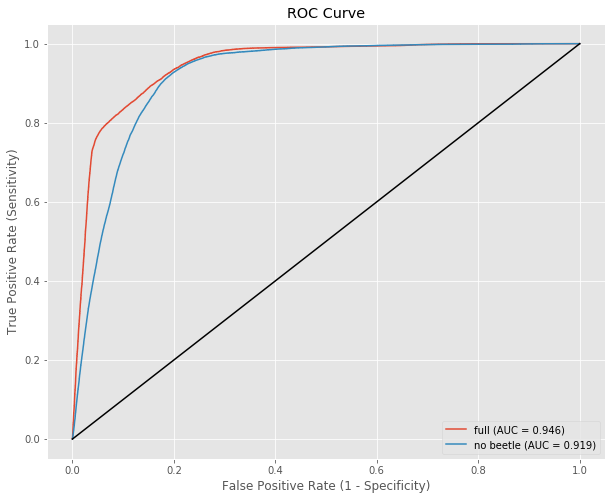

In [24]:
plt.plot(auc_metrics_full['fpr'], 
         auc_metrics_full['tpr'], 
         label='full (AUC = 0.946)');
plt.plot(auc_metrics_no_beetle['fpr'], 
         auc_metrics_no_beetle['tpr'], 
         label='no beetle (AUC = 0.919)');
plt.plot([0, 1], [0, 1], 'k');
plt.xlabel('False Positive Rate (1 - Specificity)');
plt.ylabel('True Positive Rate (Sensitivity)');
plt.title('ROC Curve');
plt.legend();

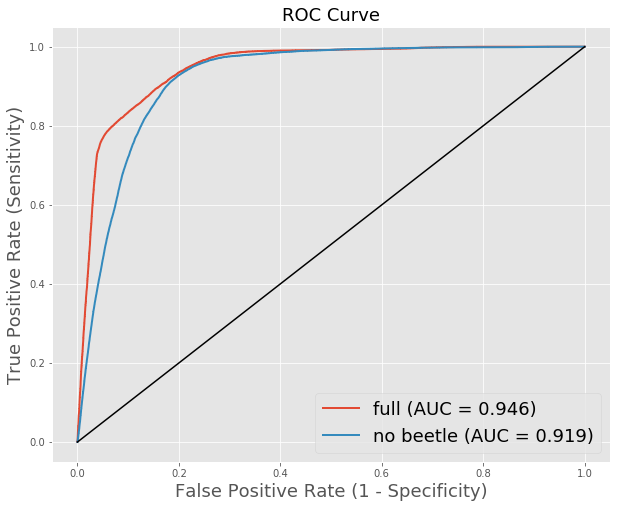

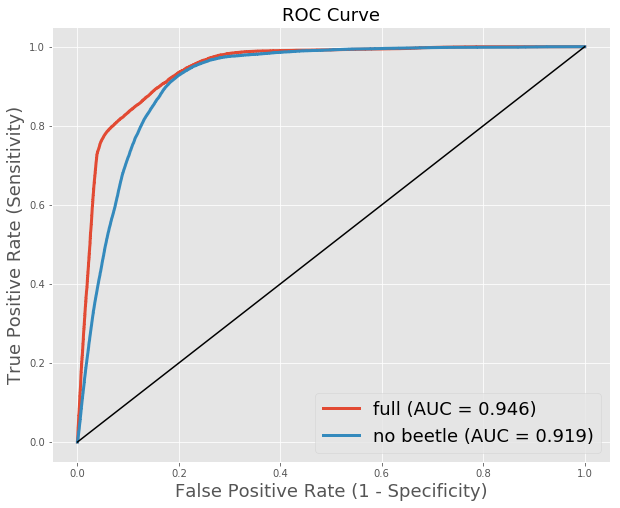

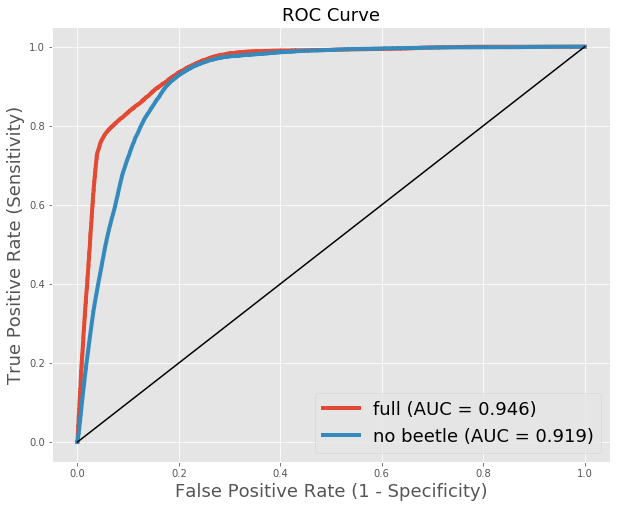

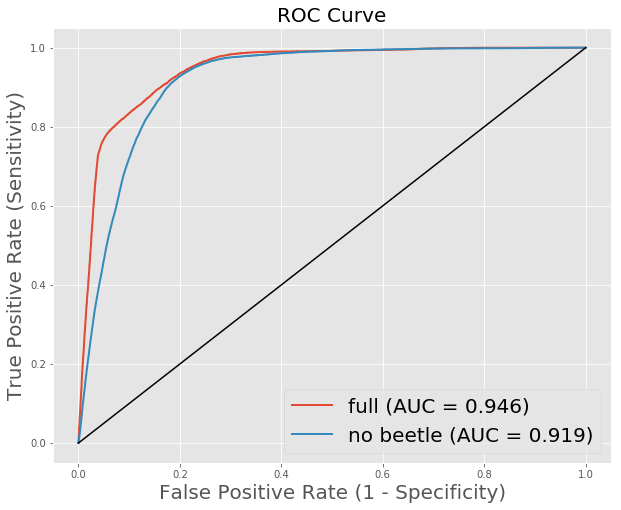

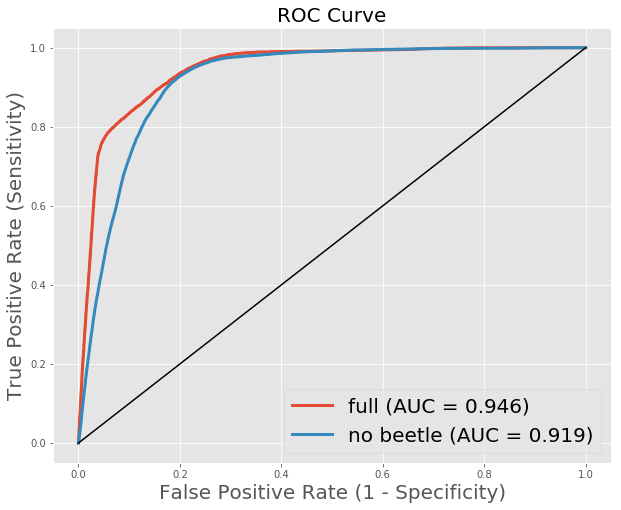

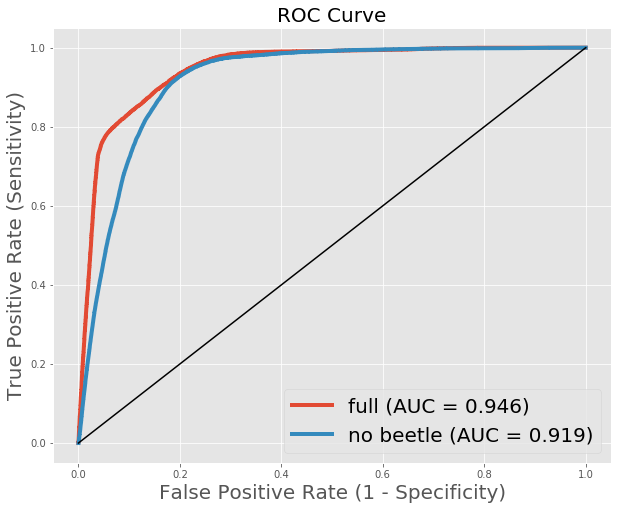

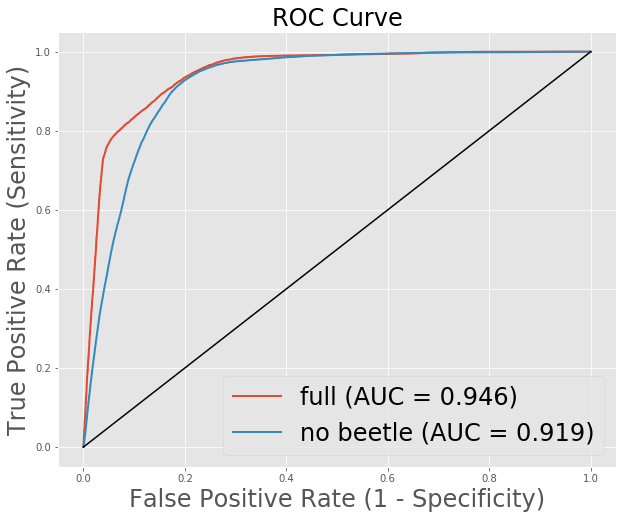

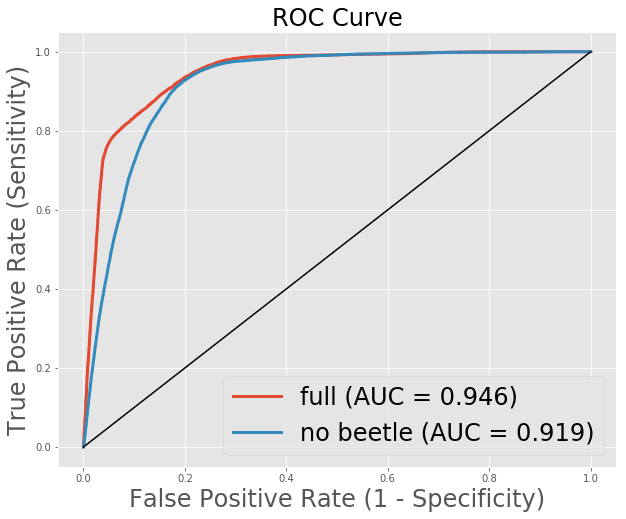

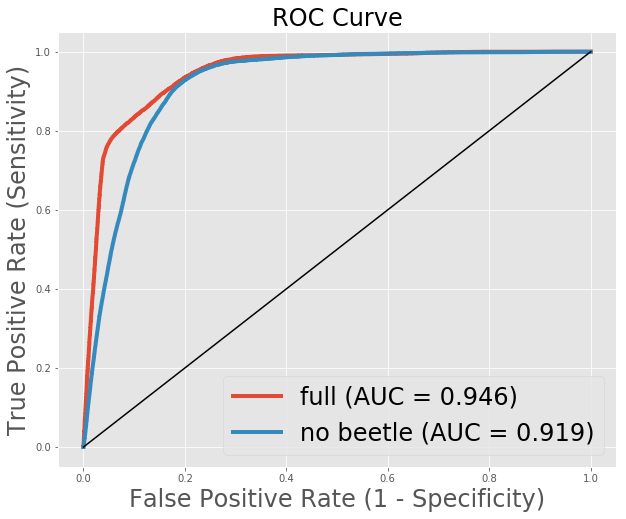

In [30]:
for font_size in [18, 20, 24]:
    for line_width in [2, 3, 4]:
        plt.figure();
        plt.plot(auc_metrics_full['fpr'], 
                 auc_metrics_full['tpr'],
                 linewidth=line_width,
                 label='full (AUC = 0.946)');
        plt.plot(auc_metrics_no_beetle['fpr'], 
                 auc_metrics_no_beetle['tpr'], 
                 linewidth=line_width,
                 label='no beetle (AUC = 0.919)');
        plt.plot([0, 1], [0, 1], 'k');
        plt.xlabel('False Positive Rate (1 - Specificity)', 
                   fontsize=font_size);
        plt.ylabel('True Positive Rate (Sensitivity)', fontsize=font_size);
        plt.title('ROC Curve', fontsize=font_size);
        plt.legend(fontsize=font_size);